## Sequence for childbirths

* Show cumulative number of chidlren in each month
* Universe: Extended Sample

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import calendar
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta

# set some nicer defaults for matplotlib
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
#rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [2]:
# helper functions

def diff_month(d1, d2):
    """
    Return the number of months between the two dates
    """
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month


In [3]:
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = int(sourcedate.year + month / 12 )
    month = month % 12 + 1
    day = min(sourcedate.day,calendar.monthrange(year,month)[1])
    return datetime(year, month, day)


# for example
d = datetime(2017, 12, 1)
add_months(d, 1)

datetime.datetime(2018, 1, 1, 0, 0)

## Read data

In [4]:
iv_df = pd.read_csv('../data/iv_df.csv')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ,marstat,mom_worked,...,num_pt2,num_work_miss_hr,num_unemp,num_oolf,num_nonwork,num_gaps,num_miss,num_nonemp_spells,num_nonemp_spells_6m,med_spells
0,2,1993,3,1959,1,3,34,2,1.0,0.0,...,78,0,25,98,0,1,0,1,1,123.0
1,3,1981,6,1961,8,3,19,1,1.0,1.0,...,1,0,28,125,0,4,0,8,6,13.5
2,8,1976,3,1958,7,3,17,1,1.0,1.0,...,2,0,11,15,1,25,21,3,2,7.5
3,16,1990,2,1958,10,3,31,3,1.0,0.0,...,50,0,0,0,0,10,0,0,0,0.0
4,19,1987,11,1957,12,3,29,2,1.0,0.0,...,0,0,0,216,0,0,0,1,1,216.0


In [5]:
iv_df.numchild.head()

0    2
1    3
2    3
3    3
4    1
Name: numchild, dtype: int64

In [6]:
dv_df = pd.read_csv('../data/dv_df.csv')
dv_df.head()

,caseid_1979,dv14,wt,allwt,dv18
0,2,5,763795,1335916,4.0
1,3,5,536272,0,5.0
2,4,3,565820,0,NaN
3,8,3,148170,1385048,1.0
4,16,2,729160,1287634,2.0


In [7]:
# merge cluster to IVs
print iv_df.shape
iv_df = iv_df.merge(dv_df, on='caseid_1979')
print iv_df.shape

(3465, 26)
(3465, 30)


In [8]:
#read birth data
dob_df = pd.read_csv('../data/childbirth.csv')
dob_df.head()

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,c7dob_m_xrnd,c7dob_y_xrnd,c8dob_m_xrnd,c8dob_y_xrnd,c9dob_m_xrnd,c9dob_y_xrnd,c10dob_m_xrnd,c10dob_y_xrnd,c11dob_m_xrnd,c11dob_y_xrnd
0,1,5,3,2,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,2,5,3,2,3,1993,11,1994,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,3,5,3,2,6,1981,10,1983,4,1986,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,4,5,3,2,8,1980,3,1997,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,1,3,1,5,1989,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [9]:
# merge again
iv_df = iv_df.merge(dob_df, on='caseid_1979')

## Construct child number monthly sequence

Monthly status:
* 1 - 1 child in this month
* 2 - 2 children in this month
* etc. 

As we constructed employment sequence, assume birht happened in the last week of the month and the number of chidlren gets updated in the following month. 

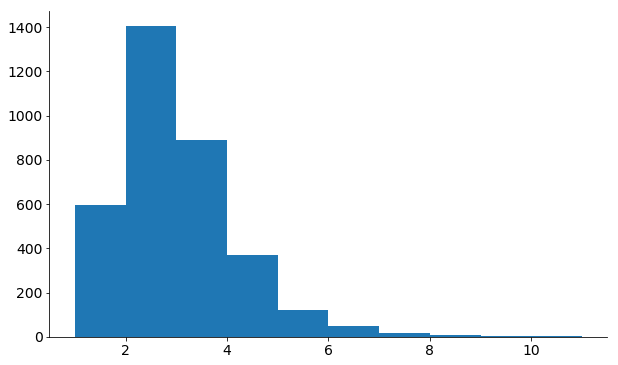

In [10]:
plt.hist(iv_df.numchild)
remove_border()

In [11]:
max(iv_df.numchild)

11

In [12]:
np.mean(iv_df.numchild>4) 

0.05916305916305916

In [13]:
np.mean(iv_df.numchild>5)

0.023665223665223667

In [14]:
data = defaultdict(list)

for i, row in iv_df.iterrows():
    if i % 100 == 0:
        print i,
    
    data['caseid_1979'].append(row['caseid_1979'])
    
    # one respondent 8511 has missing birth month, assume June
    if row['caseid_1979'] == 8511:
        childbirths = []
        for j in range(1, 12):
            if row['c%idob_y_xrnd'%j] !=-4 and row['c%idob_m_xrnd'%j] > 0:
                childbirths.append((int(row['c%idob_y_xrnd'%j]), int(row['c%idob_m_xrnd'%j])))
            else:
                childbirths.append((int(row['c%idob_y_xrnd'%j]), 6)) # assume missing month to be June
                
    else:
        childbirths = [(int(row['c%idob_y_xrnd'%j]), int(row['c%idob_m_xrnd'%j])) for j in range(1, 12) if row['c%idob_y_xrnd'%j]!=-4]
    
    
    # birth month
    birth_month = datetime(int(row['childbirth_year']), int(row['childbirth_month']), 1)
    
    # sequence start year and month
    next_month = add_months(birth_month, 1)
    y = next_month.year
    m = next_month.month
    
    num_birth = 1 # all our respondents start with 1 child - status 1 in child sequence
    
    for j in range(1, 217):
        # add monthly status first, then update num_child 
        # so that the birth starts affecting child number status in the following month
        data['month%i'%j].append(num_birth)
        
        if (y, m) in childbirths: 
            num_birth += 1
            
            
        # update counting month
        next_month = add_months(next_month, 1)
        y = next_month.year
        m = next_month.month
            
            
cols = ['caseid_1979'] + ['month%i'%j for j in range(1, 217)]
childseq_df = pd.DataFrame(data, columns=cols)
childseq_df.head()

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400

,caseid_1979,month1,month2,month3,month4,month5,month6,month7,month8,month9,...,month207,month208,month209,month210,month211,month212,month213,month214,month215,month216
0,2.0,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
1,3.0,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
2,8.0,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
3,16.0,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
4,19.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [15]:
# merge with dv and wt
childseq_df = childseq_df.merge(dv_df, on='caseid_1979')

In [16]:
# sort numchild by month
cols = ['month%i'%i for i in range(216, 0, -1)]
childseq_df = childseq_df.sort_values(cols)
childseq_df.tail()

,caseid_1979,month1,month2,month3,month4,month5,month6,month7,month8,month9,...,month211,month212,month213,month214,month215,month216,dv14,wt,allwt,dv18
1095,3268.0,1,1,1,1,1,1,1,1,1,...,8,8,8,8,8,8,5,127268,0,4.0
670,2002.0,1,1,1,1,1,1,1,1,1,...,8,8,8,8,9,9,5,405183,683559,5.0
2452,7263.0,1,1,1,1,1,1,1,1,1,...,9,9,9,9,9,9,5,151276,268351,5.0
3443,12191.0,1,1,1,1,1,1,1,1,1,...,9,9,9,9,9,9,5,210350,373143,5.0
2209,6371.0,1,1,1,1,1,1,1,1,1,...,10,10,10,10,10,10,5,167685,324575,5.0


In [17]:
N = childseq_df.shape[0]
childseq_df['order'] = range(1, N+1)

In [18]:
childseq_df.to_csv('../data/childseq_df.csv', index=False)

## Numchild > 9 in each cluster

In [46]:
for i in range(1, 6):
    print np.mean(childseq_df[childseq_df.dv18==i]['month216']>9)

0.0
0.0
0.0
0.0
0.00114285714286
